In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


In [28]:
# load data
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [29]:

data = pd.merge(transactions, customers, on='CustomerID')

In [30]:
# feature Engineering

clv = data.groupby('CustomerID')['TotalValue'].sum().reset_index()
clv.columns = ['CustomerID', 'CLV']

In [31]:
# Calculate Frequency of Transactions
frequency = data.groupby('CustomerID')['TransactionID'].count().reset_index()
frequency.columns = ['CustomerID', 'Frequency']

In [32]:

data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])
last_transaction = data.groupby('CustomerID')['TransactionDate'].max().reset_index()
last_transaction.columns = ['CustomerID', 'LastTransactionDate']
last_transaction['Recency'] = (pd.to_datetime('today') - last_transaction['LastTransactionDate']).dt.days

In [33]:

avg_transaction_value = data.groupby('CustomerID')['TotalValue'].mean().reset_index()
avg_transaction_value.columns = ['CustomerID', 'AvgTransactionValue']


In [34]:


features = pd.merge(clv, frequency, on='CustomerID')
features = pd.merge(features, last_transaction[['CustomerID', 'Recency']], on='CustomerID')
features = pd.merge(features, avg_transaction_value, on='CustomerID')

In [35]:
# add customer profile
features = pd.merge(features, customers[['CustomerID', 'Region', 'SignupDate']], on='CustomerID')

In [36]:
# preprocessing

features = pd.get_dummies(features, columns=['Region'], drop_first=True)

In [37]:


features['SignupDate'] = (pd.to_datetime('today') - pd.to_datetime(features['SignupDate'])).dt.days

In [38]:

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features.drop('CustomerID', axis=1))

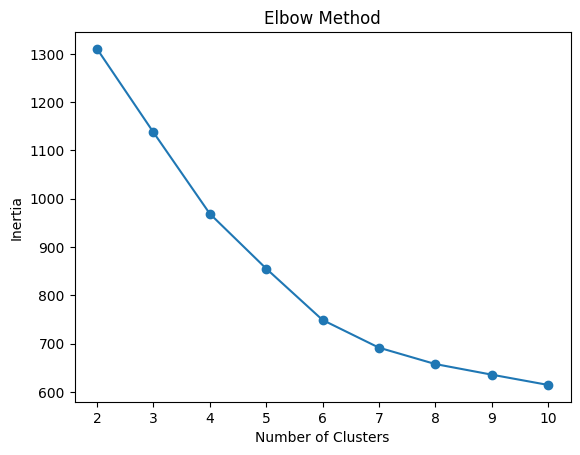

In [39]:
# clustering using K-Means

inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [40]:

k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
features['Cluster'] = kmeans.fit_predict(scaled_features)

# evaluation
db_index = davies_bouldin_score(scaled_features, features['Cluster'])
silhouette = silhouette_score(scaled_features, features['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')
print(f'Silhouette Score: {silhouette}')

Davies-Bouldin Index: 1.5615317345532933
Silhouette Score: 0.22764580319419447


In [41]:

# PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
features['PCA1'] = pca_features[:, 0]
features['PCA2'] = pca_features[:, 1]

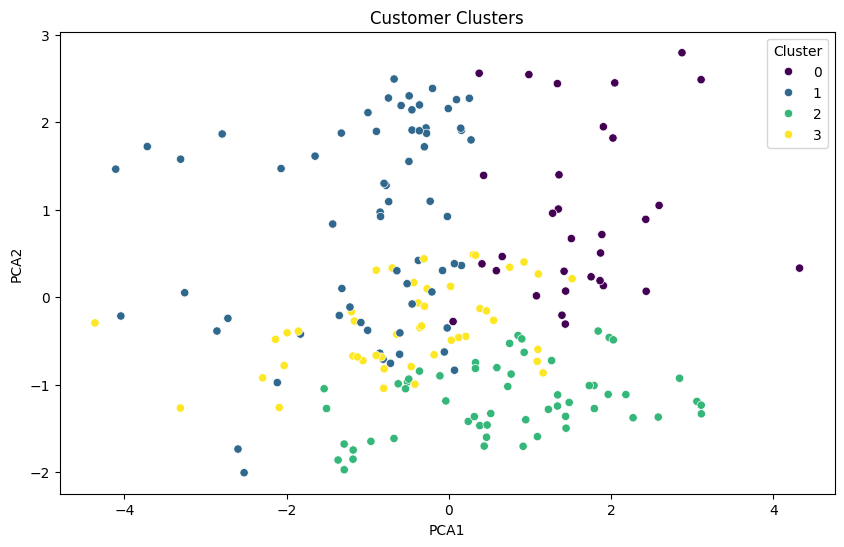

In [42]:
# plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=features, palette='viridis')
plt.title('Customer Clusters')
plt.show()

In [43]:
# cluster profiles
# exclude 'CustomerID' from the groupby operation
cluster_profiles = features.groupby('Cluster').mean(numeric_only=True)
print(cluster_profiles)

                 CLV  Frequency     Recency  AvgTransactionValue  SignupDate  \
Cluster                                                                        
0        5649.798065   8.032258   77.000000           717.732190  540.935484   
1        2358.814000   3.723077  126.630769           652.704384  486.769231   
2        3891.908929   5.375000   88.821429           713.102247  633.821429   
3        3054.936383   4.425532  109.234043           685.515907  578.000000   

         Region_Europe  Region_North America  Region_South America      PCA1  \
Cluster                                                                        
0             0.096774              0.322581              0.000000  1.617557   
1             0.000000              0.553846              0.046154 -0.997144   
2             0.000000              0.000000              1.000000  0.717424   
3             1.000000              0.000000              0.000000 -0.542674   

             PCA2  
Cluster           